# RC4558 运放

**内部电路分析与仿真**

陈硕 2024/06 初稿

RC4558 是 Raytheon 公司 1971 年推出的首款低成本双运放，它定义了 DIP-8 封装的双运放的管脚排布标准。
[RC4558 的定位是“双 741”](../opamp/rc4558-1971nov.pdf)，前者在带宽方面略好(3MHz)，较适合音频应用。日本的 JRC 公司在 1980s 仿制成功 JRC4558 (现 NJM4558)，因其[廉价](http://chenshuo.github.io/notes/media/opamp-ee1972dec.pdf)，在 80/90 年代的中低档磁带组合音响中用得很多（高档 CD 音响一般用 NE5532，带宽 10MHz）。

>  我在[一本1971年的杂志](../opamp/rc4558-1971sep.pdf)上查到了 RC4558 的上市广告，据此我认为 RC4558 是 1971 年面世的，网上[另一种说法是 1974 年](https://www.learningelectronics.net/VA3AVR/gadgets/741/741.html)，对此我不认可。Raytheon 公司于 2020 年关张。它在 1950s 销售的 [CK722](https://en.wikipedia.org/wiki/CK722) PNP 锗管是第一款低价三极管，当年在电子爱好者中很受欢迎，可以说为普及晶体管电路做了贡献。

TI 目前还在生产 RC4558，可能是因收购 National 而继承的产品线，其[技术手册](https://www.ti.com/lit/ds/symlink/rc4558.pdf)如实反应了当输入共模电压过低时会出现的相位反转 (phase reversal)现象，我们后面的仿真结果与此相符。

ElectroSmash 网站上有对 JRC4558 工作原理的详细（定性）介绍： https://www.electrosmash.com/jrc4558-analysis

从内部电路上看，TI 的 [TL072](https://leachlegacy.ece.gatech.edu/ece4435/sp08/TL071ckt.pdf) / [LF353](https://www.ti.com/lit/ds/symlink/lf353.pdf) 和 RC4558 可以说如出一辙，只是把输入的 PNP 差分管换成了 JFET。

![](../img/rc4558.png)

RC4558 的硅片版图： https://zeptobars.com/en/read/Raytheon-RC4558N-general-purpose-dual-opamp-ua741

借助分析 RC4558 内部电路，可以将模拟电路的很多知识串到一起复习，大致步骤如下：

* 分析直流工作点，计算各支路的电流
* 计算交流小信号增益，计算各级的阻抗与跨导
* 频率响应与 slew rate


In [1]:
%matplotlib inline
%load_ext tikzmagic

import math
from math import degrees, exp, log, log10
import numpy as np
from matplotlib import pyplot as plt
import scipy

def para(r1, r2):
  return (r1*r2) / (r1 + r2)

## 内部电路概述 schematic

以下是根据原厂 [1994 年的数据手册](../opamp/rc4558-1994.pdf)重绘的内部电路。

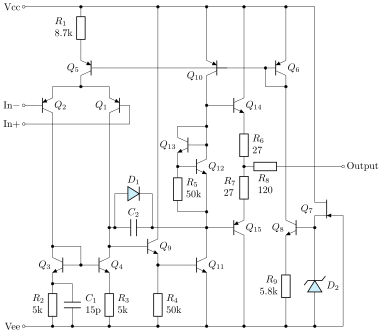

In [3]:
# DO NOT REMOVE

这个电路有 15 个晶体管，比 741 的略微简单一些，是典型的三级运放（差分输入级、中间增益级、输出缓冲级）。

> 有的英文文献把这种典型结构算成两级放大：差分输入级、共射增益级。输出级是电流缓冲，没有电压放大的功能，因此不算在内。

* Q5/Q6/Q7/Q8/Q10 是电流源，为各级提供偏置电流
* Q1/Q2/Q3/Q4 是有源负载差分输入级
* Q9/Q11 是中间增益级，其中 Q9 是射极跟随器，Q11/Q10 是高增益的有源负载共射放大器
* Q14/Q15 是推挽输出级，Q12/Q13 用于消除交越失真

注意这个电路中没有主动的限流电路，短路保护是通过电阻实现的。

以下是简化的信号通路(signal path)，与 James E. Solomon 的 1974 年经典论文[《The Monolithic Operational Amplifier: A Tutorial Study》](../appnotes/an-a.pdf) 可谓如出一辙。

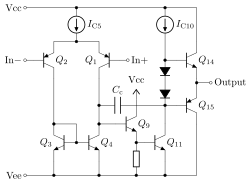

In [2]:
%%tikz -ct -f svg

\ctikzset{american currents, american voltages, european resistors}

根据数据手册提供的电路参数，结合前述论文的公式，我们可以估算很多有用的信息。


$\newcommand{\li}[1]{{i_\mathrm{#1}}}$
$\newcommand{\ui}[1]{{I_\mathrm{#1}}}$
$\newcommand{\lv}[1]{{v_\mathrm{#1}}}$
$\newcommand{\uv}[1]{{V_\mathrm{#1}}}$
$\newcommand{\ur}[1]{{R_\mathrm{#1}}}$
$\newcommand{\sm}[2]{{{#1}_\mathrm{#2}}}$

| Param | Unit | min | typ. | max |
| --- | :-: | --: | --: | --: |
| Input Offset Voltage $\uv{os}$   | mV   |   | 2 | 6 |
| Input Bias Current $\ui{IB}$ | nA   |   | 40 | 500 |
| Input Resistance $\ur{id}$ | MΩ | 0.3 | 1.0 | |
| Large Signal Voltage Gain | V/mV | 20 | 300 | |
| Unity Gain Bandwidth | MHz | 2.5 | 3 | |
| Slew rate | V/μs  | | 0.8 | |
| Power Consumption| mW | | 100 | 170 |

我认为手册上给的数据有一些不一致的地方：

* 输入电阻 $\ur{id}=1$MΩ
* 输入偏置电流 40nA，即 $\ui{IB}=40$nA

按照 hybrid-$\pi$ 模型

* $r_{\pi1}=\dfrac{\uv{T}}{\ui{IB}}=\dfrac{26\mathrm{mV}}{40\mathrm{nA}}=650$kΩ
* 那么输入电阻 $\ur{id}=2r_{\pi1}=1.3$MΩ，可能手册给的输入电阻 $\ur{id}=1$MΩ 是比较保守的数据。

根据 slew rate = 0.8 V/μs，$C_c=15$pF，用公式(18) $S\!R=\displaystyle\frac{2I_1}{C_c}$ 可算出 $2I_1=S\!R \cdot C_c = 12$μA，即 Q1 和 Q2 的偏置电流 $I_1=6$μA，$\ui{C5} = 12$μA。

估算 $\sm{\beta}{P}\approx\displaystyle\frac{I_1}{\ui{IB}}=\frac{6}{0.04}=150$

跨导 $\sm{g}{m1}=\displaystyle\frac{I_1}{\uv{T}}=\frac{6}{26}\approx 0.23$mS

由公式(16)可计算单位增益带宽 $f_t = \displaystyle\frac{\sm{g}{m1}}{2\pi C_c}=\frac{0.23}{15\times 2\pi }\approx 2.45$MHz

这里又出现了不一致，我推测是因为手册上给的 slew rate 参数偏保守。从手册上给的图可以看出，slew rate 的上升和下降是不对称的，SR$+\approx 1.33$，SR$-\approx 1.0$。

<img alt="RC4558 Slew Rate" src="../img/rc4558-slewrate.png" width="50%">

假如我们取 slew rate = 1.0 V/μs 重新计算，可得出 $2I_{1} = 15$μA，$\sm{g}{m1}=\displaystyle\frac{I_1}{V_T}=\frac{7.5}{26}$， $f_t = \displaystyle\frac{\sm{g}{m1}}{2\pi C_c}\approx 3.06$MHz。这个数据看上去就比较协调了。

## DC 工作点计算与仿真

原理图上只给了电阻的阻值，没有其他器件参数。我们按一般双极型集成电路的器件参数来建模，但是晶体管的面积之比就无从得知了。
参数取自 Paul & Meyer, _Analysis and Design of Analog Integrated Circuits_, 5e.

| 参数 | NPN | 横向 PNP |
| :-: | --: | --: |
| $\ui{S}$ | $\ui{SN}=5\mathrm{fA}$ | $\ui{SP}=2\mathrm{fA}$ |
| $\beta$ | $\sm{\beta}{N}=200$ | $\sm{\beta}{P}=50$ |
| $\uv{A}$ | $\uv{AN}= 130$V | $\uv{AP}=50$V |

早期模拟集成电路中的 PNP 管大致有横向 (lateral)和衬底 (substrate) 两大类，Q15 应该是衬底 PNP，这里统一按 lateral PNP 的参数来计算。


### 偏置电路

RC4558 的偏置电路比 741 简单：

* JFET Q7 给 Zener 二极管 D2 提供一个基本稳定的工作电流，D2 给 Q8 的基极提供参考电压
* Q8/R9/D2 产生基本不随电源电压变化的参考电流 $\ui{ref}=\ui{C8}\approx\dfrac{\uv{ZD2}-\uv{BE8}}{R_9}$
* Q6/Q10 是基本的镜像电流源，为 Q11 提供偏置电流 $I_2$, 我们假定 $I_2 = \ui{C10} = \ui{C8}=\ui{ref}$
* Q5/Q6 是 Widlar 微电流源，为差分输入级提供偏置电流 $\ui{C5}=2I_1$

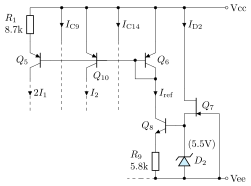

In [25]:
%%tikz -ct -f svg

**温度补偿**

$\sm{g}{m} = \dfrac{\ui{C}}{\uv{T}}$，而 $\uv{T}$ 与绝对温度 $T$ 成正比，因此如果 $\ui{C}$ 恒定，那么温度越高 $\sm{g}{m}$ 越小，这不利于电路的稳定工作。
例如 $r_\pi=\dfrac{\beta}{\sm{g}{m}}$，而 $\beta$ 随温度升高也会增大，因此随温度升高 $r_\pi$ 会增加，相应的 $I_\mathrm{bias}$ 会减小。

解决办法是设法让 $\ui{C}$ 也随温度增加而增大，这样就能让 $\sm{g}{m}$ 基本不变，从而使得电路参数稳定。RC4558 的偏置电路有一定的温度补偿效果（据我观察）： $\uv{BE8}$ 有负温度系数，而 $D_2$ 通常是正温度系数，二者叠加（不是抵消），使得 R9 两端的电压有正温度系数，从而让主参考电流 $\ui{C8}$ 也有正温度系数，借此保持 $\sm{g}{m}$ 大体稳定。

$\uv{BE}-\ui{C}$ 关系，便于估算工作点 

| 参数 | NPN | 横向 PNP |
| --- | --- | --- |
| $\ui{S}$ | 5fA | 2fA |
| $\uv{BE}=0.60$V | 52.6uA | 21.0uA |
| $\uv{BE}=0.65$V | 0.360mA | 0.144mA |
| $\uv{BE}=0.7$V | 2.46mA | 0.985mA |

### 偏置电流 bias currents

以下估算以 $\beta \gg 1$ 为前提，因此忽略基极电流，认为 $\ui{E}\approx\ui{C}$

Zener 二极管 D2 的稳定电压未知，不妨假设是 5.6V，那么 Q8 的 E 极对 Vee 的电压约为 $5.6-0.6=5$V，$\ui{ref}\approx 5/5.8 \approx 0.86$mA.
因此 $I_2 = \ui{C10}\approx\ui{C11}\approx 0.86$mA.

> RC4136 四运放的电路与 RC4558 相同，[其手册上给的击穿电压是 5.5V](../opamp/rc4136-1994.pdf)，但是 R9 改成了 15kΩ，仅供参考。

接下来考虑 Q5/R1 的微电流源

$\ui{C5}R_1 = \uv{T}\ln\dfrac{\ui{ref}}{\ui{C5}}$

In [16]:
def Ic5(x):
    Ic = x
    Vt = 26
    Iref = 860
    R4 = 8.7
    return Ic * R4 - Vt * np.log(Iref / Ic)

root = scipy.optimize.root_scalar(Ic5, x0=0.1)
if root.converged:
    Ic = root.root
    print('Ic5 = %.2f uA' % (Ic))

Ic5 = 12.62 uA


故 $I_1=\ui{C1}=\ui{C2}=\ui{C3}=\ui{C4}=\dfrac{\ui{C5}}{2} = 6.31$uA.

中间级的工作点，由 $\ui{C11}=I_2\approx 0.86$mA 可知：

$\uv{BE11} = \uv{T}\ln\dfrac{\ui{C11}}{\ui{SN}} = 26\ln\dfrac{0.86\mathrm{mA}}{5\mathrm{fA}}\approx 0.673$V

$\ui{E9}=\ui{R4}+\ui{B11} = \dfrac{\uv{BE11}}{R_4} + \dfrac{\ui{C11}}{\beta_\mathrm{N}} = \dfrac{0.673}{50} + \dfrac{0.86}{200} \approx 0.0178$mA.

$\uv{BE9} = \uv{T}\ln\dfrac{\ui{C9}}{\ui{SN}}=26\ln\dfrac{17.8\mathrm{uA}}{5\mathrm{fA}}\approx 0.572$V


最后，计算输出级。

先估算 Q12/Q13 电流。

* $\ui{E12} + \ui{R5}=I_2=0.86$mA

* 假定大部分电流从 Q12 流过，即 $\ui{E12}\gg\ui{R5}$，则 $\ui{C12}\approx I_2$
* $\uv{BE12}=\uv{T}\ln\dfrac{\ui{C12}}{\ui{SN}}\approx  26\ln\dfrac{0.86\mathrm{mA}}{5\mathrm{fA}}\approx 0.673$V
* $\ui{E13}=\ui{R5}+\ui{B12} = \dfrac{\uv{BE12}}{R_5} + \dfrac{\ui{C12}}{\beta_\mathrm{N}} = \dfrac{0.673}{50} + \dfrac{0.86}{200} \approx 0.0178$mA. 可见确实符合前面的电流分配假设。


最后计算 Q14/Q15，先忽略 R6 和 R7 上的电压，我们就得到了一个 translinear 电路。
假设输出管的面积是普通管子的 3 倍，仿照 [741 的计算方法](/741/#24t)。

* $\ui{E12}\ui{E13}=\dfrac{1}{3^2}\ui{E14}\ui{E15}$
* $\ui{E14}=\ui{E15}=3\sqrt{\ui{E12}\ui{E13}}=3\sqrt{860\times 17.8}=371$uA

至此，各支路的电流已求出。

| 三极管 | 手算 | 仿真 |
| --- | --: | --: |
| Q1/Q2/Q3/Q4 | 6.31μA | ~6.9μA |
| Q5 | 12.62μA | 14.04μA |
| Q8/Q6 | 860μA | 840μA/808μA |
| Q10/Q11 | 860μA | 975μA/978μA|
| Q9 | 17.8μA | 17.8μA| 
| Q12| 860μA | 956μA |
| Q13 | 17.8μA | 18.2μA| 
| Q14/Q15 | 371μA | ~240μA |

静态供电电流（暂不考虑 Q7/D2 的工作电流 $\ui{D2}$）为 $2I_1 + I_2 + \ui{ref} + \ui{C9}+\ui{C14}\approx 0.0126 + 0.86\times 2 + 0.0178 + 0.371\approx 2.12$mA

> 手册上给出的静态空载供电电流为 3.6mA，每路运放运放为 1.8mA，跟这里的计算有所不符。我感觉这里计算得到的 $\ui{ref}$ 可能偏大了一些，$\ui{C11}$ 应该用不了 0.86mA 这么大。


在计算过程中我们没有用到电源电压，也暂时忽略了 Early 效应的影响。
换句话说，RC4558 的直流工作点与电源电压基本无关，这也是它能宽电压工作的主要原因。

> 741 的主参考电流是靠 39kΩ 的 R5 来提供，大致跟电源电压成正比。

## AC 小信号增益

我们先一级一级计算：

* 输入阻抗
* 输出阻抗
* 电压增益

最后把结果汇总就得到了整个电路的开环增益。

### 差分输入级 differential pair

三极管的 hybrid-pi 小信号模型：

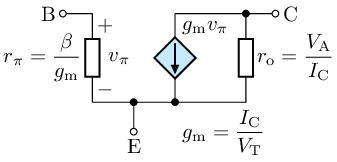

In [10]:
%%tikz -ct
\ctikzset{european resistors, american voltages}
\ctikzset{transistors/arrow pos=end, transistors/fill=cyan!20}
\ctikzset{diodes/fill=cyan!20, csources/fill=cyan!20}
\newcommand{\sm}[2]{\ensuremath{{#1}_\mathrm{#2}}}
    
\draw (0,0) to [R, l_={$r_\pi=\displaystyle\frac{\beta}{\sm{g}{m}}$}, v^>={$v_\pi$}, bipoles/length=0.8cm] ++(0, -1.5) coordinate (E);
\draw (0,0) to [short, -o] ++(-0.5, 0) node [left] {B};
%\draw [dashed] (Q.E) to [short] (Q.E |- E);
\draw (E) ++(0.7, 0) to [short, *-o] ++(0, -0.5) node [below] {E};
\draw (1.4, 0) coordinate (C)
  node [below right] {$\sm{g}{m}v_\pi$}
  to [american controlled current source, bipoles/length=1cm] (C|-E) node [circ] {}
  node [below right] {$\sm{g}{m}=\displaystyle\frac{\sm{I}{C}}{\sm{V}{T}}$};
\draw (C) to [short] ++(1.2, 0) coordinate (D)
  to [R, l={$\sm{r}{o}=\displaystyle\frac{\sm{V}{A}}{\sm{I}{C}}$}, bipoles/length=0.8cm] (D|-E)-- (E);
\draw (D) to [short, *-o] ++(0.5, 0) node [right] {C};

* 跨导 $\sm{g}{m}=\dfrac{\ui{C}}{\uv{T}}=\dfrac{6.31\mathrm{uA}}{26\mathrm{mV}}$
* Q1 单管输入电阻 $r_{\pi1}=\dfrac{\sm{\beta}{P}}{\sm{g}{m}}=\dfrac{50\times 26}{6.31} = 206$kΩ
* $r_\pi$ 在国内教材上一般叫 $\sm{r}{be}$ 或 $\sm{r}{b'e}$
* $v_\pi$ 在国内教材上一般叫 $\sm{v}{be}$ 或 $\sm{v}{b'e}$
* $\sm{r}{o}$ 在国内教材上一般叫 $\sm{r}{ce}$

**差分输入电阻** $\sm{R}{id}=2r_{\pi1}=2\times 206=412$kΩ，手册上给的典型数据是 1MΩ，可能实际的 $\sm{\beta}{P}$ 不是 50 而是 100 甚至 150。

**输出电阻** $\sm{R}{o1}=\sm{r}{o1}/\!/\sm{R}{o4}$

$\sm{r}{o1} = \dfrac{\uv{AP}}{\ui{C1}} = \dfrac{50V}{6.31\mathrm{uA}}\approx 7.924$MΩ

电流源负载的输出电阻 $\sm{R}{o4} = \sm{r}{o4}[1+\sm{g}{m}(R_3/\!/ r_{\pi4})]$

* $\sm{r}{o4}=\dfrac{\uv{AN}}{\ui{C1}} = \dfrac{130V}{6.31\mathrm{uA}}\approx 20.6$MΩ

* $ r_{\pi4}=\dfrac{\sm{\beta}{N}}{\sm{g}{m}}=\dfrac{200\times 26\mathrm{mV}}{6.31\mathrm{uA}}=824$kΩ
* 因 $R_3\ll r_{\pi4}$，$R_3/\!/ r_{\pi4}\approx R_3=5$kΩ
* $\sm{R}{o4} = \sm{r}{o4}(1+\sm{g}{m}R_3)=\sm{r}{o4}(1+\dfrac{5000\times 6.31\mathrm{uA}}{\uv{T}})=2.213 \sm{r}{o4}=45.6$MΩ
* $\sm{R}{o1}=\sm{r}{o1}/\!/\sm{R}{o4}\approx 6.75$MΩ

### 增益级 common-emitter

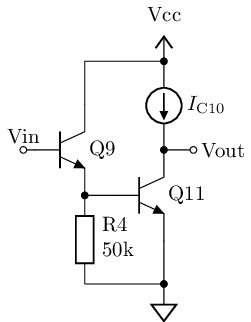

In [11]:
# DO NOT REMOVE

先求出本级的输入电阻 $\sm{R}{i2}$，这也是第一级的负载电阻。因此，第一级的电压增益
$\sm{A}{v1}=\sm{g}{m1}(\sm{R}{o1} /\!/ \sm{R}{i2})$

Q9 是射极跟随器，其负载电阻为 $R_4 /\!/ r_{\pi11}$

* $r_{\pi9}=\sm{\beta}{N}\dfrac{\uv{T}}{\ui{C9}}=\dfrac{200\times 26\mathrm{mV}}{17.8\mathrm{uA}}=292$kΩ
* $r_{\pi11}=\dfrac{\uv{T}}{\ui{B11}}=\sm{\beta}{N}\dfrac{\uv{T}}{\ui{C11}}=\dfrac{26\mathrm{mV}}{0.86\mathrm{mA}}\times 200=6046.5$Ω
* $\sm{R}{i2}=r_{\pi9}+(1+\sm{\beta}{N})(R_4 /\!/ r_{\pi11})$
* $\sm{R}{i2}=292 + 201\times 5.3942=1376$kΩ


* $\sm{R}{o1} /\!/ \sm{R}{i2} = \sm{r}{o1} /\!/ \sm{R}{o4} /\!/ \sm{R}{i2} = (7.924 /\!/ 45.6 /\!/ 1.376)=1.143$MΩ

由此可算出第一级的电压增益 $\sm{A}{v1}$ 

$\sm{A}{v1}=\sm{g}{m1}(\sm{R}{o1} /\!/ \sm{R}{i2}) = \dfrac{6.31\mathrm{uA}}{26\mathrm{mV}}\times 1.143$MΩ = 277

第二级电压增益主要由 Q11 及其有源负载 Q10 提供。
前面算出其偏置电流为 $\ui{C10}=\ui{C11}=0.86$mA，因此第二级的输出电阻

$\sm{R}{o2}=(\sm{r}{o11}/\!/\sm{r}{o10})= \dfrac{\uv{AP}}{\ui{C10}}/\!/\dfrac{\uv{AN}}{\ui{C11}}\approx 42$kΩ

输出级为射极跟随器，不妨认为其输入阻抗 $\sm{R}{i3}\gg \sm{R}{o2}$，从而粗略估算本级的电压增益 $\sm{A}{v2}$ 为

$\sm{A}{v2}=\sm{g}{m11}(\sm{r}{o11}/\!/\sm{r}{o10})=\dfrac{\uv{AN}\uv{AP}}{\uv{T}(\uv{AN}+\uv{AP})} = \dfrac{130\times 50}{26\times(130+50)}\times 1000=1389$

可见整个电路的增益主要由第二级提供。总的增益为 $\sm{A}{v1}\sm{A}{v2}=277\times 1389=384,753$，合 111.7dB。手册给出的典型增益为 300,000，与计算基本符合。

## 频率响应与压摆率

Slew rate 用 James Solomon 论文中的公式 (18) 可以直接算出来：$S\!R = \dfrac{2I_1}{C_c}=\dfrac{12.6}{15}\approx 0.84$V/μs，与数据手册的 0.8V/μs 基本符合。

单位增益带宽 GBW 用上文提到的公式 (16) 也容易计算：$f_t = \displaystyle\frac{\sm{g}{m1}}{2\pi C_c}=\frac{I_1}{2\pi C_c\,\uv{T}}=\frac{6.31}{2\pi\times 15 \times 26 }\approx 2.58$MHz，也接近数据手册的 3.0MHz 典型值。

增大 $I_1$ 可以提高速度（slew rate 和 GBW），但是会降低输入电阻 $\sm{R}{id}$ 并增加输入偏置电流，这是 BJT 运放的一组基本矛盾，一个解决办法是降低输入级的 $\sm{g}{m}$。(Jim Solomon, William Davis, P. Lee, "A Self-Compensated Monolithic Operational Amplifier With Low Input Current and High Slew Rate.")

## SPICE 仿真

In [2]:
import ngspyce as ng

def print_op(show_ib=True, show_ie=False):
  op = ng.operating_point()
  for k in sorted(op.keys()):
    if k[0] == '@' or '#branch' in k:
        if '[is]' in k:
            continue
        if '[ie]' in k and not show_ie:
            continue
        if '[ib]' in k and not show_ib:
            continue
        current = op[k][0]
        k = k.replace('q.x.', '')
        k = k.replace('r.x.', '')
        if abs(current) > 1e-6:
            print('%10s = %8.2f uA' % (k, 1e6*current))
        else:
            print('%10s = %8.2f nanoA' % (k, 1e9*current))
    else:
        voltage = op[k][0]
        k = k.replace('x.', '')
        if abs(voltage) > 10e-3:
            print('%10s = %8.4f V' % (k, voltage))
        else:
            print('%10s = %8.1f uV' % (k, 1e6*voltage))

def diff_op(lhs, rhs, show_ie=False):
  for k in sorted(lhs.keys()):
    old = lhs[k][0]
    new = rhs[k][0]
    if k[0] == '@' or '#branch' in k:
        delta = new - old
        if np.abs(delta) < 1e-9:
            continue
        if '[ie]' in k and not show_ie:
            continue
        k = k.replace('q.x.', '')
        k = k.replace('r.x.', '')
        if delta < 1e-6:
            print('%15s %10.3f uA, %10.3f uA, delta %10.3f nanoA' %
              (k, old * 1e6, new * 1e6, (new - old) * 1e9))
        else:
            print('%15s %10.3f uA, %10.3f uA, delta %10.3f uA' %
              (k, old * 1e6, new * 1e6, (new - old) * 1e6))
    else:
        delta = new - old
        k = k.replace('x.', '')
        if delta < 1e-3:
            print('%15s %10.3f mV, %10.3f mV, delta %10.3f uV' %
              (k, old * 1e3, new * 1e3, (new - old)* 1e6))
        else:
            print('%15s %10.3f mV, %10.3f mV, delta %10.3f milliV' %
              (k, old * 1e3, new * 1e3, (new - old)* 1e3))


### 开环增益

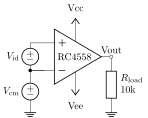

In [9]:
%%tikz -ct -f svg

\ctikzset{baseline, american currents, american voltages, european resistors}

\draw (0, 0) node [op amp, noinv input up] (OA) {RC4558};

\draw (OA.+) to [short] ++(-0.5, 0) coordinate (IN)
  to [V, l_={$V_\mathrm{id}$}, bipoles/length=1cm] (IN|-OA.-) -- (OA.-);
\draw (OA.-) to [short, -*] ++(-0.5, 0) coordinate (INV)
  to [V, l_={$V_\mathrm{cm}$}, bipoles/length=1cm] ++(0, -1.5) coordinate (G) node [tlground] {};
\draw (OA.out) node [ocirc] {} node [above] {Vout}
  to [R,l2={$R_\mathrm{load}$ and 10k},  bipoles/length=1.2cm] (OA.out|-G) node [tlground] {};
\draw (OA.up) -- ++(0, 0.4) node [vcc] {Vcc};
\draw (OA.down) -- ++(0, -0.4) node [vee] {Vee};

In [3]:
ng.circ('''
Vcc   vcc  0   15V
Vee   vee  0  -15V

Vid   in+  in-  DC -339.5u AC 1V
Vcm   in-  0    0
Rload out  0    10k

* Bias

J1  q8b  vcc  vcc  PJFET
D2  vee  q8b       DZ
Q8  q6c  q8b  q8e  NPN
R9  q8e  vee       5.8k
Q6  q6c  q6c  vcc  PNP
Q10 q14b q6c  vcc  PNP
Q5  q5c  q6c  q5e  PNP
R1  vcc  q5e       8.7k

* Input

Q1 q9b in+ q5c PNP
Q2 q3c in- q5c PNP
Q3 q3c q3c r2  NPN
Q4 q9b q3c r3  NPN
R2 r2  vee 5k
R3 r3  vee 5k
C1 r2  vee 15pF

* Gain

Q9  vcc  q9b  q11b NPN
Q11 q15b q11b vee  NPN
R4  q11b vee  50k
C2  q9b  q15b 15pF
D1  q9b  q15b D

* Vbe multiplier

Q13 q14b q14b q12b NPN
Q12 q14b q12b q15b NPN
R5  q12b q15b 50k

* Output

Q14 vcc q14b q14e NPN 3
Q15 vee q15b q15e PNP 3
R6  q14e mid  27
R7  mid  q15e 27
R8  mid  out  120

.model D  D(IS=1fA)
.model DZ D(IS=10fA BV=5.6)
.model NJFET NJF(VTO=-5.6 BETA=1e-3 LAMBDA=1e-3)
.model PJFET PJF(VTO=-1  BETA=2e-4 LAMBDA=1e-3)

.model npn NPN ( Bf=200 Br=2.0 VAf=125V Is=5fA Tf=0.35ns
+ Rb=200 Rc=200 Re=2 Cje=1.0pF Vje=0.70V Mje=0.33 Cjc=0.3pF
+ Vjc=0.55V Mjc=0.5 Cjs=3.0pF Vjs=0.52V Mjs=0.5)

.model pnp PNP ( Bf=50 Br=4.0 VAf=50V Is=2fA Tf=30ns
+ Rb=300 Rc=100 Re=10 Cje=0.3pF Vje=0.55V Mje=0.5 Cjc=1.0pF
+ Vjc=0.55V Mjc=0.5 Cjs=3.0pF Vjs=0.52V Mjs=0.5)

* .options savecurrents
* .save all @q5[ic] @q1[ic] @q8[ic] @d2[id]
* .save @q9[ic] @q10[ic] @q11[ic]
''')
print_op(0)

       in+ =   -339.5 uV
       in- =      0.0 uV
       mid =  -0.0185 V
       out =  -0.0183 V
      q11b = -14.3273 V
      q12b =   0.0236 V
      q14b =   0.5931 V
      q14e =  -0.0120 V
      q15b =  -0.6510 V
      q15e =  -0.0251 V
       q3c = -14.4216 V
       q5c =   0.5616 V
       q5e =  14.8760 V
       q6c =  14.2956 V
       q8b =  -9.4415 V
       q8e = -10.1079 V
       q9b = -13.7638 V
        r2 = -14.9657 V
        r3 = -14.9656 V
       vcc =  15.0000 V
vcc#branch = -2291.63 uA
vcm#branch =   215.63 nanoA
       vee = -15.0000 V
vee#branch =  2293.25 uA
vid#branch =   108.52 nanoA


Output swing -13.29 to 14.09


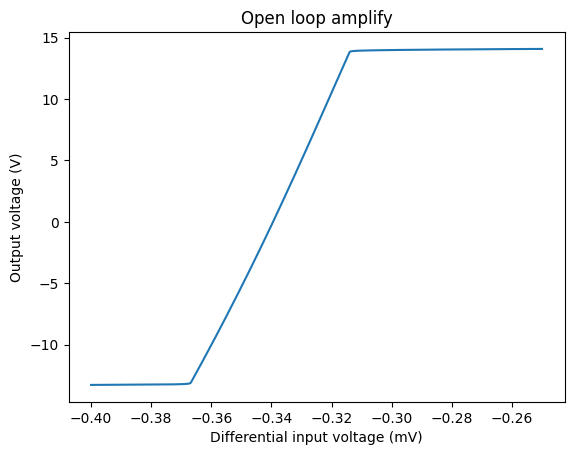

In [4]:
ng.cmd('dc vid -400u -250u 0.1u')
Vin = ng.vector('in+')
Vout = ng.vector('out')
plt.plot(Vin*1e3, Vout)
cross = sum(Vout < 0)
plt.xlabel('Differential input voltage (mV)')
plt.ylabel('Output voltage (V)')
plt.title('Open loop amplify')
print('Output swing %.2f to %.2f' % (min(Vout), max(Vout)))

In [17]:
cross_point = np.sum(Vout < 0)
assert Vout[cross_point] > 0 and Vout[cross_point-1] < 0
print('Vos = %.1f uV Vout = %.1f mV' % (Vin[cross_point] * 1e6, Vout[cross_point]*1e3))

assert Vout[0] < -10 and Vout[-1] > 10
start = np.sum(Vout < -10)
end =  np.sum(Vout < 10)
deltaVin = Vin[end] - Vin[start]
print('Delta Vin for 10V delta in Vout: %.1f uV' % (1e6*deltaVin/2))
deltaVout = Vout[end] - Vout[start]
gain = deltaVout / deltaVin
print('Gain = %.0f V/mV, %.1f dB' % (gain/1e3, 20*log10(gain)))

Vos = -339.4 uV Vout = 33.5 mV
Delta Vin for 10V delta in Vout: 19.5 uV
Gain = 513 V/mV, 114.2 dB


Output range: -13.24 V to 14.13 V


(-15.0, 15.0)

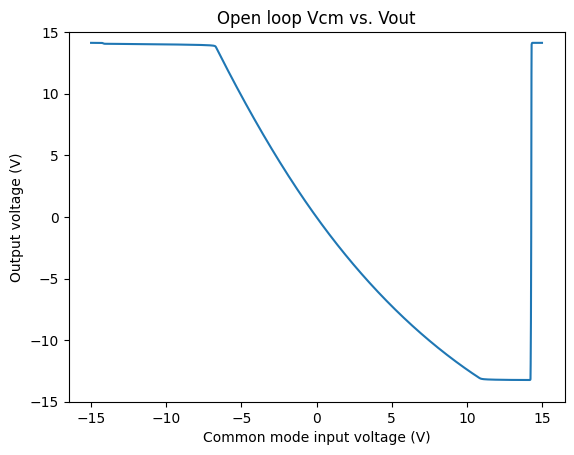

In [6]:
ng.cmd('dc vcm -15V 15V 1m')

Vout = ng.vector('out')
Vin = ng.vector('in-')
plt.plot(Vin, Vout)
plt.xlabel('Common mode input voltage (V)')
plt.ylabel('Output voltage (V)')
plt.title('Open loop Vcm vs. Vout')
print('Output range: %.2f V to %.2f V' % (min(Vout), max(Vout)))
plt.ylim([-15, 15])

### 直流传递函数

In [15]:
ng.cmd('tf v(out) vid')
ng.vectors()

{'output_impedance_at_V(out)': array([667.22147205]),
 'vid#Input_impedance': array([290983.61828406]),
 'Transfer_function': array([518314.71798351])}

In [16]:
ng.cmd('tf v(out) vcm')
ng.vectors()

{'output_impedance_at_V(out)': array([667.22147205]),
 'vcm#Input_impedance': array([2.54033552e+08]),
 'Transfer_function': array([-1.69147443])}

### 频率响应

Gain at        0 Hz is  518223.33  Phase   -1.1 deg 
Gain at        1 Hz is  509329.24  Phase  -10.7 deg 
Gain at       10 Hz is  242728.36  Phase  -62.1 deg 
Gain at      100 Hz is   27432.87  Phase  -87.0 deg 
Gain at     1000 Hz is    2747.09  Phase  -89.8 deg 
Gain at    10000 Hz is     274.63  Phase  -90.8 deg 
Gain at   100000 Hz is      26.71  Phase  -98.1 deg 
Gain at  1000000 Hz is       1.59  Phase -110.2 deg 
Gain at 10000000 Hz is       0.15  Phase -140.6 deg 
Gain 114.3 dB
1.58 MHz


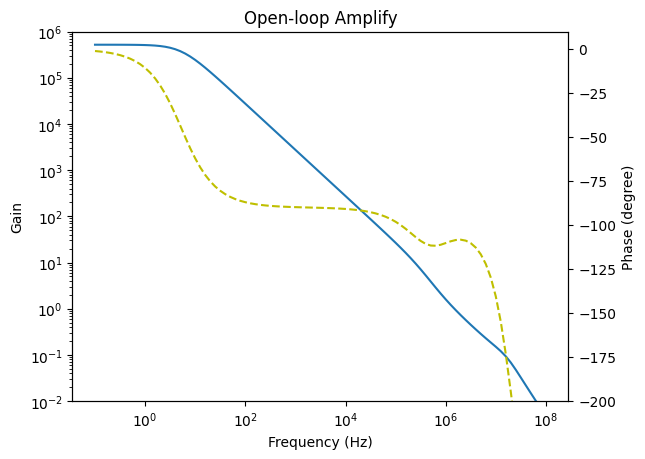

In [25]:
ng.cmd('AC dec 10 0.1Hz 100MegHz')
freq = ng.vector('frequency')
out = ng.vector('out')

fig, ax = plt.subplots()
plt.loglog(freq, np.abs(out))
plt.title('Frequency response')
plt.ylabel('Gain')
plt.xlabel('Frequency (Hz)')
for i in range(len(freq)):
    if int(freq[i]*100) in np.power(10, range(10)):
        print('Gain at %8.0f Hz is %10.2f  Phase %6.1f deg ' % (freq[i], np.abs(out[i]), degrees(np.angle(out[i]))))
plt.ylim(1e-2, 1e6)

ax2 = ax.twinx()
phase =  np.unwrap(np.angle(out))/math.pi*180
plt.semilogx(freq, phase, '--y')

plt.ylim(-200, 10)
plt.ylabel('Phase (degree)')

print('Gain %.1f dB' % (log10(np.abs(out[0]))*20))
cross = sum(np.abs(out) > 1)
print('%.2f MHz' % (freq[cross]/1e6))

### Slew rate

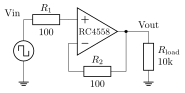

In [37]:
%%tikz -ct -f svg

\ctikzset{american currents, american voltages, european resistors}
\ctikzset{diodes/fill=cyan!20, transistors/arrow pos=end,bipoles/length=1.2cm}

\draw (0, 0) node [op amp, noinv input up] (OA) {\small RC4558};

\draw (OA.-) to [short] ++(0, -1) coordinate (INV)
  to [R,l={$R_2$}, a={$100$}] (INV-|OA.out) -- (OA.out);
\draw (OA.out) to [short, *-] ++(0.8, 0) node [above] {Vout}
  to [R,l2={$R_\mathrm{load}$ and 10k}] ++(0, -1.8)  coordinate (G) node [tlground] {};
\draw (OA.+)
  to [R, l_={$R_1$}, a^=100] ++(-1.6, 0) coordinate (VIN)
 node [above left] {Vin}
  to [sqV] (VIN|-G) node [tlground] {};


In [8]:
ng.circ('''
* power supplies

V1  vcc 0  15V
V2  vee 0 -15V

Vin  vin    0   DC -5 PULSE -5 5 10u 10N 10N 20U 100U 
R1   in+  vin   100
R2   in-  out   100

Rload out    0   10000

X  in+ in- vcc vee out RC4558

.include rc4558.cir

.options savecurrents
''')
print_op(0)

ERROR:ngspyce.sharedspice:Note: Starting dynamic gmin stepping
ERROR:ngspyce.sharedspice:Note: Dynamic gmin stepping completed


@c.x.c1[i] =     0.00 nanoA
@c.x.c2[i] =     0.00 nanoA
@d.x.d1[id] =    -0.01 nanoA
@d.x.d2[id] =  -220.88 uA
@j.x.j1[id] =   224.44 uA
@j.x.j1[ig] =    -0.02 nanoA
@j.x.j1[igd] =    -0.02 nanoA
  @q10[ic] = -1033.99 uA
  @q11[ic] =  1043.29 uA
  @q12[ic] =  1015.05 uA
  @q13[ic] =    18.50 uA
  @q14[ic] =    80.86 uA
  @q15[ic] =  -571.64 uA
   @q1[ic] =    -7.01 uA
   @q2[ic] =    -6.99 uA
   @q3[ic] =     6.92 uA
   @q4[ic] =     6.94 uA
   @q5[ic] =   -14.24 uA
   @q6[ic] =  -808.83 uA
   @q8[ic] =   840.29 uA
   @q9[ic] =    18.34 uA
    @r1[i] =    14.44 uA
    @r2[i] =     6.95 uA
    @r3[i] =     6.97 uA
    @r4[i] =    13.51 uA
    @r5[i] =    13.53 uA
    @r6[i] =    81.21 uA
    @r7[i] =   581.29 uA
    @r8[i] =  -500.08 uA
    @r9[i] =   843.85 uA
    @r1[i] =   119.30 nanoA
    @r2[i] =   117.62 nanoA
 @rload[i] =  -499.96 uA
       in+ =  -5.0000 V
       in- =  -4.9996 V
       out =  -4.9996 V
 v1#branch = -2212.16 uA
 v2#branch =  2712.00 uA
       vcc =  15.0000 V
  

ERROR:ngspyce.sharedspice:Note: Starting dynamic gmin stepping
ERROR:ngspyce.sharedspice:Note: Dynamic gmin stepping completed


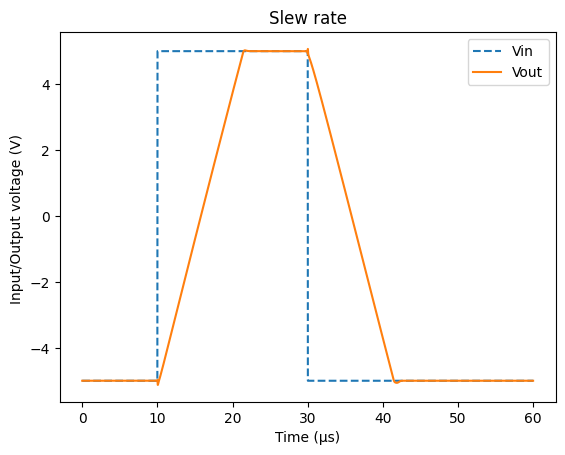

In [9]:
ng.cmd('tran 10n 60u')
t = ng.vector('time')
Vout = ng.vector('out')
Vin = ng.vector('vin')
plt.plot(t*1e6, Vin, '--', label='Vin')
plt.plot(t*1e6, Vout, label='Vout')
plt.ylabel('Input/Output voltage (V) ')
plt.xlabel('Time (μs)')
plt.title('Slew rate')
plt.legend()

### 相位反转

In [11]:
ng.circ('''
* power supplies
V1  vcc 0  15V
V2  vee 0  0V

Vin  vin    0    0
R1   in+  vin  100
R2   in-  out  100

Rload out    0   10000

X  in+ in- vcc vee out RC4558

.include rc4558.cir
.options savecurrents
''')
print_op(0)

@c.x.c1[i] =     0.00 nanoA
@c.x.c2[i] =     0.00 nanoA
@d.x.d1[id] =    -0.01 nanoA
@d.x.d2[id] =  -205.50 uA
@j.x.j1[id] =   209.44 uA
@j.x.j1[ig] =    -0.01 nanoA
@j.x.j1[igd] =    -0.01 nanoA
  @q10[ic] =    -7.03 uA
  @q11[ic] =     0.02 nanoA
  @q12[ic] =     0.00 nanoA
  @q13[ic] =     0.08 nanoA
  @q14[ic] =  1405.91 uA
  @q15[ic] =    -0.01 nanoA
   @q1[ic] =   -10.04 nanoA
   @q2[ic] =    -0.01 nanoA
   @q3[ic] =     0.01 nanoA
   @q4[ic] =     0.01 nanoA
   @q5[ic] =   -13.70 uA
   @q6[ic] =  -736.29 uA
   @q8[ic] =   839.12 uA
   @q9[ic] =     2.23 uA
    @r1[i] =    13.92 uA
    @r2[i] =     0.01 nanoA
    @r3[i] =     0.01 nanoA
    @r4[i] =     2.24 uA
    @r5[i] =     0.07 nanoA
    @r6[i] =  1412.95 uA
    @r7[i] =    -0.00 nanoA
    @r8[i] =  1412.95 uA
    @r9[i] =   843.06 uA
    @r1[i] =    13.69 uA
    @r2[i] =    -0.04 nanoA
 @rload[i] =  1412.95 uA
       in+ =   1369.1 uV
       in- =  14.1295 V
       out =  14.1295 V
 v1#branch = -2477.45 uA
 v2#branch =  105

Output range: 1.25 V to 14.13 V


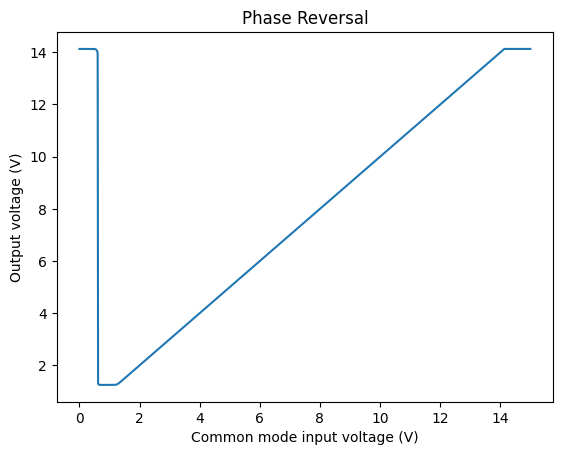

In [12]:
ng.cmd('dc vin 0V 15V 1m')

Vout = ng.vector('out')
Vin = ng.vector('vin')
# plt.figure(figsize=(4, 3))
plt.plot(Vin, Vout)
plt.xlabel('Common mode input voltage (V)')
plt.ylabel('Output voltage (V)')
plt.title('Phase Reversal')
print('Output range: %.2f V to %.2f V' % (min(Vout), max(Vout)))
# plt.ylim([-15, 15])
plt.savefig("cmrr.pdf", format="pdf", bbox_inches="tight")

待续。。。